<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Training_ALIGNN_model_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of contents

1. Installing [ALIGNN](https://github.com/usnistgov/alignn)
2. Example training for regression on 50 materials,
3. Using pre-trained models to make fast predictions
4. Using ALIGNN-FF model to predict the unrelaxed energy (fast), optimized strcture and energy, and EV curve
5. Train ALIGNN-FF on a new dataset
6. Training [JARVIS-DFT](https://jarvis.nist.gov/jarvisdft) 2D exfoliation energy model 
7. Training [QM9](http://quantum-machine.org/datasets/) U0 model

In [1]:
!pip install alignn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.6/263.6 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.3/973.3 KB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
import os
!pwd
os.chdir('/content')
# Clone ALIGNN repo to get example folder
if not os.path.exists('alignn'):
  !git clone https://github.com/usnistgov/alignn.git

os.chdir('alignn')
# Install using setup.py in case pip didn't work
# !python setup.py develop

#!pip install dgl-cu111 # Colab has cuda 11.1

/content
Cloning into 'alignn'...
remote: Enumerating objects: 3330, done.
remote: Counting objects: 100% (924/924), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 3330 (delta 711), reused 780 (delta 643), pack-reused 2406
Receiving objects: 100% (3330/3330), 32.70 MiB | 7.98 MiB/s, done.
Resolving deltas: 100% (1887/1887), done.


Example folder with id_prop.csv and 'POSCAR files.'

In [3]:
!ls "alignn/examples/sample_data"

config_example.json	  POSCAR-JVASP-64045.vasp  POSCAR-JVASP-86097.vasp
id_prop.csv		  POSCAR-JVASP-64240.vasp  POSCAR-JVASP-86205.vasp
POSCAR-JVASP-107772.vasp  POSCAR-JVASP-64377.vasp  POSCAR-JVASP-86436.vasp
POSCAR-JVASP-10.vasp	  POSCAR-JVASP-64584.vasp  POSCAR-JVASP-86726.vasp
POSCAR-JVASP-13526.vasp   POSCAR-JVASP-64664.vasp  POSCAR-JVASP-86968.vasp
POSCAR-JVASP-1372.vasp	  POSCAR-JVASP-64719.vasp  POSCAR-JVASP-89025.vasp
POSCAR-JVASP-14014.vasp   POSCAR-JVASP-64906.vasp  POSCAR-JVASP-89265.vasp
POSCAR-JVASP-14441.vasp   POSCAR-JVASP-65062.vasp  POSCAR-JVASP-90228.vasp
POSCAR-JVASP-14873.vasp   POSCAR-JVASP-65101.vasp  POSCAR-JVASP-90532.vasp
POSCAR-JVASP-15345.vasp   POSCAR-JVASP-655.vasp    POSCAR-JVASP-90856.vasp
POSCAR-JVASP-1996.vasp	  POSCAR-JVASP-676.vasp    POSCAR-JVASP-97378.vasp
POSCAR-JVASP-21210.vasp   POSCAR-JVASP-76308.vasp  POSCAR-JVASP-97499.vasp
POSCAR-JVASP-22556.vasp   POSCAR-JVASP-76309.vasp  POSCAR-JVASP-97570.vasp
POSCAR-JVASP-27901.vasp   POSCAR-JVASP-76312.

# 50 materials and their bandgap data generated with the script [generate_sample_data_reg.py](https://github.com/usnistgov/alignn/blob/main/alignn/examples/sample_data/scripts/generate_sample_data_reg.py)

# Train a model for 3 epochs and batch size of 2. Other parameters are provided in `config_example.json` file. For an involved training, use higher batch size such as 16 and epochs such as 300.

Command line train_folder.py is used below.

In [4]:
import time
t1=time.time()
!train_folder.py --root_dir "alignn/examples/sample_data" --epochs 3 --batch_size 2 --config "alignn/examples/sample_data/config_example.json" --output_dir=temp
t2=time.time()
print ('Time in s',t2-t1)

DGL backend not selected or invalid.  Assuming PyTorch for now.
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
MAX val: 6.149
MIN val: 0.0
MAD: 1.0520696
Baseline MAE: 0.7102749999999998
data range 6.149 0.0
  0% 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/alignn/graphs.py:237: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  g.ndata["lattice_mat"] = torch.tensor(
100% 40/40 [00:01<00:00, 36.30it/s]
df                                                 atoms  ... target
0   {'lattice_mat': [[-0.0, 4.517300851474054, 4.5...  ...  0.000
1   {'lattice_mat': [[7.709535704177289, 2.46207e-...  ...  0.000
2   {'lattice_

In [5]:
!ls

alignn	LICENSE.rst  pyproject.toml  README.md	setup.py  temp


The model produces *.pt files which are the trained models.

In [6]:
!ls temp

checkpoint_2.pt		 mad
checkpoint_3.pt		 prediction_results_test_set.csv
config.json		 prediction_results_train_set.csv
history_train.json	 test_data_data_range
history_val.json	 train_data_data_range
ids_train_val_test.json  val_data_data_range


We can load a trained model above as the following:

In [7]:
from alignn.models.alignn import ALIGNN, ALIGNNConfig
import torch
output_features =  1
filename = 'temp/checkpoint_3.pt'
device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
model = ALIGNN(ALIGNNConfig(name="alignn", output_features=output_features))
model.load_state_dict(torch.load(filename, map_location=device)["model"])
model.eval()

ALIGNN(
  (atom_embedding): MLPLayer(
    (layer): Sequential(
      (0): Linear(in_features=92, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
    )
  )
  (edge_embedding): Sequential(
    (0): RBFExpansion()
    (1): MLPLayer(
      (layer): Sequential(
        (0): Linear(in_features=80, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
    )
    (2): MLPLayer(
      (layer): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
    )
  )
  (angle_embedding): Sequential(
    (0): RBFExpansion()
    (1): MLPLayer(
      (layer): Sequential(
        (0): Linear(in_features=40, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.

Now, we can build graph for a given structure and make a prediction as follows:

In [8]:
from jarvis.core.atoms import Atoms
from alignn.graphs import Graph
cutoff = 8.0
max_neighbors = 12
atoms = Atoms.from_poscar('alignn/examples/sample_data/POSCAR-JVASP-10.vasp')
g, lg = Graph.atom_dgl_multigraph(
    atoms, cutoff=float(cutoff), max_neighbors=max_neighbors,
)
out_data = (
    model([g.to(device), lg.to(device)])
    .detach()
    .cpu()
    .numpy()
    .flatten()
    .tolist()
)
print ('output', out_data[0])

output 2.280003309249878


/content/alignn/alignn/graphs.py:237: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  g.ndata["lattice_mat"] = torch.tensor(


We have already trained multiple models on several large datasets which can be used with the pretrained.py executable.

Use pretrained models such as models trained on JARVIS-DFT, QM9, Materials project, hMOF etc. databases. The models are downloaded from figshare. See the list here: https://github.com/usnistgov/alignn/blob/main/alignn/pretrained.py#L28

In [9]:
!pretrained.py -h

usage: pretrained.py
       [-h]
       [--model_name MODEL_NAME]
       [--file_format FILE_FORMAT]
       [--file_path FILE_PATH]
       [--cutoff CUTOFF]
       [--max_neighbors MAX_NEIGHBORS]

Atomistic
Line Graph
Neural
Network
Pretrained
Models

optional arguments:
  -h, --help
    show this
    help
    message and
    exit
  --model_name MODEL_NAME
    Choose a
    model from
    these 40 mo
    dels:jv_for
    mation_ener
    gy_peratom_
    alignn, jv_
    optb88vdw_t
    otal_energy
    _alignn, jv
    _optb88vdw_
    bandgap_ali
    gnn, jv_mbj
    _bandgap_al
    ignn, jv_sp
    illage_alig
    nn, jv_slme
    _alignn, jv
    _bulk_modul
    us_kv_align
    n, jv_shear
    _modulus_gv
    _alignn,
    jv_n-Seebec
    k_alignn,
    jv_n-powerf
    act_alignn,
    jv_magmom_o
    szicar_alig
    nn, jv_kpoi
    nt_length_u
    nit_alignn,
    jv_avg_elec
    _mass_align
    n, jv_avg_h
    ole_mass_al
    ignn, jv_ep
    sx_alignn, 
    jv_mepsx_al
    ignn, jv_ma
    x_efg_

In [10]:
!pretrained.py --model_name jv_formation_energy_peratom_alignn --file_format poscar --file_path alignn/examples/sample_data/POSCAR-JVASP-10.vasp

100% 47.5M/47.5M [00:03<00:00, 15.8MiB/s]
Using chk file jv_formation_energy_peratom_alignn/checkpoint_300.pt from  ['jv_formation_energy_peratom_alignn/checkpoint_300.pt']
Path /usr/local/bin/jv_formation_energy_peratom_alignn.zip
Predicted value: jv_formation_energy_peratom_alignn alignn/examples/sample_data/POSCAR-JVASP-10.vasp [-0.70339435338974]


Using ALIGNN-FF pretrained model to get unrelaxed energy and relaxed structure

In [11]:
!run_alignn_ff.py --file_path alignn/examples/sample_data/POSCAR-JVASP-10.vasp --task="unrelaxed_energy"

model_path /usr/local/lib/python3.8/dist-packages/alignn/ff
/usr/local/lib/python3.8/dist-packages/alignn/graphs.py:237: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  g.ndata["lattice_mat"] = torch.tensor(
Energy(eV) (-11.776981830596924, array([[ 0.0000000e+00,  3.7252903e-09,  9.3132257e-10],
       [ 0.0000000e+00,  2.1071173e-07, -1.7778256e-03],
       [ 0.0000000e+00, -2.1059532e-07,  1.7777842e-03]], dtype=float32))


In [12]:
!run_alignn_ff.py --file_path alignn/examples/sample_data/POSCAR-JVASP-10.vasp --task="optimize"

model_path /usr/local/lib/python3.8/dist-packages/alignn/ff
OPTIMIZATION
/usr/local/lib/python3.8/dist-packages/alignn/graphs.py:237: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  g.ndata["lattice_mat"] = torch.tensor(
a= 1.678 Ang b= 2.906 Ang c= 6.221 Ang Volume= 60.658 amu/a3 PE=-11.77698 eV KE= 0.00000 eV T= 0.000 K 
a= 1.676 Ang b= 2.903 Ang c= 6.223 Ang Volume= 60.556 amu/a3 PE=-11.77832 eV KE= 0.00000 eV T= 0.000 K 
a= 1.673 Ang b= 2.897 Ang c= 6.228 Ang Volume= 60.355 amu/a3 PE=-11.78092 eV KE= 0.00000 eV T= 0.000 K 
a= 1.668 Ang b= 2.888 Ang c= 6.235 Ang Volume= 60.062 amu/a3 PE=-11.78462 eV KE= 0.00000 eV T= 0.000 K 
a= 1.661 Ang b= 2.877 Ang c= 6.245 Ang Volume= 59.692 amu/a3 PE=-11.78918 eV KE= 0.00000 eV T= 0.000 K 
a= 1.653 Ang b= 2.863 Ang c= 6.259 Ang Volume=

In [13]:
!run_alignn_ff.py --file_path alignn/examples/sample_data/POSCAR-JVASP-10.vasp --task="ev_curve"

model_path /usr/local/lib/python3.8/dist-packages/alignn/ff
/usr/local/lib/python3.8/dist-packages/alignn/graphs.py:237: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  g.ndata["lattice_mat"] = torch.tensor(
E [-11.59964418 -11.74018407 -11.77280045 -11.78283548 -11.78363013
 -11.77698183 -11.76358366 -11.74409294 -11.71868992 -11.68687391]
V [52.00698610745743, 53.66666028373519, 55.3612736919685, 57.09119028249023, 58.85677400563329, 60.6583888117305, 62.496398651114745, 64.3711674741189, 66.28305923107584, 68.23243787231843]


Train ALIGNN-FF model

In [14]:
!train_folder_ff.py --root_dir "alignn/examples/sample_data_ff" --config "alignn/examples/sample_data_ff/config_example_atomwise.json" --output_dir=temp

len dataset 50
MAX val: -24.52653862
MIN val: -42.04135008
MAD: 7.884625411000001
Baseline MAE: 7.128754169400001
data range -24.52653862 -42.04135008
  0% 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/alignn/graphs.py:237: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  g.ndata["lattice_mat"] = torch.tensor(
100% 40/40 [00:00<00:00, 45.41it/s]
df        target  ...    jid
0  -24.558198  ...  15609
1  -42.030165  ...  15608
2  -42.040710  ...  15608
3  -24.544487  ...  15609
4  -24.549292  ...  15609
5  -42.040186  ...  15608
6  -42.016896  ...  15608
7  -42.041135  ...  15608
8  -42.030172  ...  15608
9  -29.311899  ...  15607
10 -42.041350  ...  15608
11 -24.549425  ...  15609
12 -42.038933  ...  15608
13 -42.040889  ...  15608
14 -42.039553  ...  15608
15 -42.

The generated model is saved as best_model.pt

In [16]:
!ls -altr temp

total 110996
-rw-r--r-- 1 root root 48648565 Feb  7 17:07 checkpoint_2.pt
-rw-r--r-- 1 root root 48648565 Feb  7 17:07 checkpoint_3.pt
-rw-r--r-- 1 root root      244 Feb  7 17:07 prediction_results_test_set.csv
-rw-r--r-- 1 root root      222 Feb  7 17:07 prediction_results_train_set.csv
drwxr-xr-x 6 root root     4096 Feb  7 17:13 ..
-rw-r--r-- 1 root root      489 Feb  7 17:14 ids_train_val_test.json
-rw-r--r-- 1 root root       68 Feb  7 17:14 mad
-rw-r--r-- 1 root root       34 Feb  7 17:14 train_data_data_range
-rw-r--r-- 1 root root       34 Feb  7 17:14 val_data_data_range
-rw-r--r-- 1 root root       34 Feb  7 17:14 test_data_data_range
-rw-r--r-- 1 root root     1785 Feb  7 17:14 config.json
-rw-r--r-- 1 root root 16177149 Feb  7 17:15 best_model.pt
-rw-r--r-- 1 root root    98076 Feb  7 17:15 Train_results.json
-rw-r--r-- 1 root root     9479 Feb  7 17:15 Val_results.json
-rw-r--r-- 1 root root      249 Feb  7 17:17 history_train.json
-rw-r--r-- 1 root root      254 Feb  7 1

#Train a model for JARVIS-DFT 2D Exfoliation energy

There are quite a few datasets available here:https://jarvis-tools.readthedocs.io/en/master/databases.html
In the following example, we will use the JARVIS-DFT 2D dataset

Get data in id_prop.csv format

In [17]:
from jarvis.db.figshare import data as jdata
from jarvis.core.atoms import Atoms
import os

cwd = os.getcwd() #current working directory
temp_dir_name = "DataDir_ExfoEnergy" 
os.makedirs(temp_dir_name)
os.chdir(temp_dir_name)

dft_3d = jdata("dft_3d")
prop = "exfoliation_energy" #"optb88vdw_bandgap"
f = open("id_prop.csv", "w")
# count = 0
for i in dft_3d:
    atoms = Atoms.from_dict(i["atoms"])
    jid = i["jid"]
    poscar_name = "POSCAR-" + jid + ".vasp"
    target = i[prop]
    if target != "na":
        atoms.write_poscar(poscar_name)
        f.write("%s,%6f\n" % (poscar_name, target))
        # count += 1
        # if count == max_samples:
        #     break
f.close()

os.chdir(cwd)

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 40.8M/40.8M [00:02<00:00, 15.8MiB/s]


Loading the zipfile...
Loading completed.


In [ ]:
!ls -altr  DataDir_ExfoEnergy/*.vasp | wc -l


813


In [ ]:
 !wc -l DataDir_ExfoEnergy/id_prop.csv 

813 DataDir_ExfoEnergy/id_prop.csv


In [ ]:
import time
t1=time.time()
!train_folder.py --root_dir "DataDir_ExfoEnergy" --epochs 1 --batch_size 64 --config "alignn/examples/sample_data/config_example.json" --output_dir="ExfoEnOut"
t2=time.time()
print ('Time in s',t2-t1)

MAX val: 948.93
MIN val: 0.03
MAD: 62.629814227293544
Baseline MAE: 61.033631528964854
data range 948.93 0.03
100% 650/650 [00:13<00:00, 48.88it/s]
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
building line graphs
100% 650/650 [00:00<00:00, 1636.83it/s]
data range 388.51 18.3
100% 81/81 [00:01<00:00, 47.49it/s]
building line graphs
100% 81/81 [00:00<00:00, 977.37it/s]
data range 903.94 0.95
100% 81/81 [00:01<00:00, 47.50it/s]
building line graphs
100% 81/81 [00:00<00:00, 1042.25it/s]
n_train: 650
n_val: 81
n_test: 81
version='112bbedebdaecf59fb18e11c929080fb2f358246' dataset='user_data' target='target' atom_features='cgcnn' neighbor_strategy='k-nearest' id_tag='jid' random_seed=123 classification_threshold=None n_val=None n_test=None n_train=None train_ratio=0.8 val_ratio=0.1 test_ratio=0.1 target_multiplication_factor=None epochs=1 batch_size=64 weight_decay=1e-05 learning_ra

In [ ]:
!ls ExfoEnOut	 

checkpoint_1.pt     ids_train_val_test.json	      test_data_data_range
config.json	    mad				      train_data_data_range
history_train.json  prediction_results_test_set.csv   val_data_data_range
history_val.json    prediction_results_train_set.csv


Here checkpoints are the model parameter files that can be loaded in torch library to make predictions such as [this example](https://github.com/usnistgov/alignn/blob/main/alignn/scripts/predict.py).

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
df = pd.read_csv('/content/alignn/ExfoEnOut/prediction_results_test_set.csv')

These are predictions on 10 % held dataset that the model has never seen

In [ ]:
df

,id,target,prediction
0,POSCAR-JVASP-12918.vasp,27.170000,-6.187871
1,POSCAR-JVASP-2035.vasp,82.290001,-7.342460
2,POSCAR-JVASP-13942.vasp,87.809998,-7.392377
3,POSCAR-JVASP-278.vasp,144.320007,-7.004450
4,POSCAR-JVASP-10173.vasp,33.700001,-6.653560
...,...,...,...
76,POSCAR-JVASP-4364.vasp,54.290001,-8.038940
77,POSCAR-JVASP-29480.vasp,78.639999,-8.734681
78,POSCAR-JVASP-28375.vasp,55.480000,-7.636129
79,POSCAR-JVASP-590.vasp,88.519997,-7.158464


In [ ]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
alignn 2022.9.22 requires matplotlib>=3.4.1, but you have matplotlib 3.1.3 which is incompatible.


Text(0, 0.5, 'ALIGNN predictions (meV)')

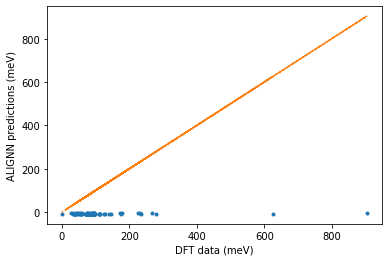

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(df['target'],df['prediction'],'.')
plt.plot(df['target'],df['target'],'-.')
plt.xlabel('DFT data (meV)')
plt.ylabel('ALIGNN predictions (meV)')

In [ ]:
# from jarvis.db.figshare import data as jdata
# from jarvis.core.atoms import Atoms
# import os

# temp_dir_name = "DataDir_QM9_U0" 
# os.makedirs(temp_dir_name)
# os.chdir(temp_dir_name)

# dft_3d = jdata("qm9_std_jctc") #jdata("dft_3d")
# prop = "U0" #"exfoliation_energy" #"optb88vdw_bandgap"
# f = open("id_prop.csv", "w")
# # count = 0
# for i in dft_3d:
#     atoms = Atoms.from_dict(i["atoms"])
#     jid = i["id"]
#     poscar_name = "POSCAR-" + jid + ".vasp"
#     target = i[prop]
#     if target != "na":
#         atoms.write_poscar(poscar_name)
#         f.write("%s,%6f\n" % (poscar_name, target))
#         # count += 1
#         # if count == max_samples:
#         #     break
# f.close()

# os.chdir(cwd)

In [ ]:
pwd

'/content/alignn/DataDir_QM9_U0'

In [ ]:
!ls

Changing the cut-off in config_example.json as 5,  n_train as 110000, n_val as 10000, n_test as 10829

In [ ]:
# from jarvis.db.jsonutils import loadjson, dumpjson
# config = loadjson("alignn/examples/sample_data/config_example.json")
# config['cutoff'] = 5.0
# config['n_train'] = 110000
# config['n_val'] = 10000
# config['n_test'] = 10829
# dumpjson(data=config, filename="config_qm9.json")

Run for 1000 epochs instead of 5 here to get reasonable performance/MAE

In [ ]:
# import time
# t1=time.time()
# !train_folder.py --root_dir "DataDir_QM9_U0" --epochs 5 --batch_size 64 --config "config_qm9.json" --output_dir="DataDir_QM9U0out"
# t2=time.time()
# print ('Time in s',t2-t1)

In [ ]:
!pip freeze

absl-py==1.3.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.3
aiosignal==1.2.0
alabaster==0.7.12
albumentations==1.2.1
alignn==2022.9.22
altair==4.2.0
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==3.0.0
autograd==1.5
Babel==2.10.3
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.8
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.8
certifi==2022.9.24
cffi==1.15.1
cftime==1.6.2
chardet==3.0.4
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==1.5.0
cmake==3.22.6
cmdstanpy==1.0.7
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.3
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.1
cycler==0.11.0
cymem==2.0.7
Cython==0.29.32
daft==0.0.4
dask==2022.2.0
datascience==0.17.5
debugpy==1.0